# ENTREGA DEEP LEARNING

## Integrantes:

 + Jorge Peralta Fernández-Revuelta Lechuga

 + Alberto García Martín

 + Ignacio Urretavizcaya Tato

 + Juan López Segura

## Primer paso (Sólo si se desean entrenar modelos en W&B):

 + En terminal, habiendo activado el entorno: wandb login

 + Pegar la API KEY: a8be9b6fcd7b2715da8018421e06657d1e080477

In [1]:
from cnn import CNN
import torchvision
from cnn import load_data
from cnn import load_model_weights
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import wandb
import random

## Model and data loading

In [2]:
# Pytorch has many pre-trained models that can be used for transfer learning
classification_models = torchvision.models.list_models(module=torchvision.models)
print(classification_models)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'squeezenet1_0

In [3]:
# Load data and model 
train_dir = 'data/training'
valid_dir = 'data/validation'

train_loader, valid_loader, num_classes = load_data(train_dir, 
                                                    valid_dir, 
                                                    batch_size=32, 
                                                    img_size=224) # ResNet50 requires 224x224 images
model = CNN(torchvision.models.resnet50(weights='DEFAULT'), num_classes)

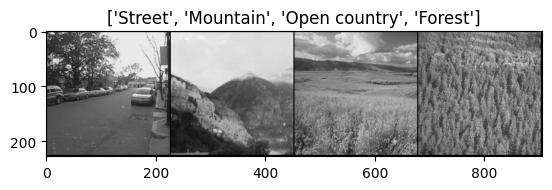

In [4]:
# Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(valid_loader.dataset[i][1])
out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])

## Train

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
history = model.train_model(train_loader, valid_loader, optimizer, criterion, epochs=1)

Epoch 1/1 - Train Loss: 2.6464, Train Accuracy: 0.2643
Epoch 1/1 - Validation Loss: 2.5534, Validation Accuracy: 0.4687


In [ ]:
model.save('resnet50-1epoch')

## Predict

#### Load model

In [ ]:
# Load model
model_weights = load_model_weights('resnet50-1epoch')
my_trained_model = CNN(torchvision.models.resnet50(weights='DEFAULT'), num_classes)
my_trained_model.load_state_dict(model_weights)

<All keys matched successfully>

## Results

In [ ]:
predicted_labels = my_trained_model.predict(valid_loader)

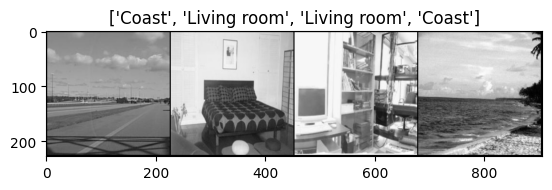

In [ ]:
# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(predicted_labels[i])

out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])


## Modelo en W&B

In [ ]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="ML2-CNN-PROJECT",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "my_trained_model",
    "dataset": "YourDataset",
    "epochs": 10,
    }
)

In [ ]:
# Instancia tu modelo de CNN

# Simula el entrenamiento
epochs = 10
for epoch in range(epochs):
    # Entrena tu modelo aquí (reemplaza esto con tu propio código de entrenamiento)
    # Por ejemplo:
    model.train_model(train_loader, valid_loader, optimizer, criterion, epochs=1)
    
    # Evalúa tu modelo en el conjunto de prueba y registra métricas en W&B
    loss, acc = my_trained_model.predict(valid_loader)
    wandb.log({"loss": loss, "accuracy": acc})

# Finaliza el run de W&B
wandb.finish()


In [ ]:
# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset
    
    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})
    
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()